## Code

In [1]:
import numpy as np
import pandas as pd

import sklearn.datasets as skldata
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

import scipy.special as scspec
import scipy.optimize as scopt

import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import jax.numpy as jnp
from jax.config import config

config.update("jax_enable_x64", True)

### Data <a href="https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"> link

#### Data preprocessing

We will employ widely-adopted methods to preprocess our training data. This step is essential, because without it final TFIDF matrix will have too many features. We first tokenize the string in the dataset, and then transform ech token to its normal form. Then we filter all words that appear less then 50 times, and also filter all stopwords

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from pymorphy2 import MorphAnalyzer

nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximzubkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tokenizer = RegexpTokenizer(r'\w{2,}')
morph = MorphAnalyzer()

def tokenize(text: str):
    tokenized = tokenizer.tokenize(text)
    return [morph.parse(token)[0].normal_form for token in tokenized]

In [4]:
df = pd.read_csv("dataset_imdb.csv").sample(2000)

df["sentiment"] = (df["sentiment"] == "positive") + 0

vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=50, tokenizer=tokenize)

X = jnp.array(vectorizer.fit_transform(df.review).todense())
y = jnp.array(df.sentiment.values)

w0 = jax.random.normal(jax.random.PRNGKey(0), (X.shape[1],))

In [5]:
print(f"TF-IDF matrix of size {X.shape}, with {round(100 * (X != 0).sum() / (X.shape[0] * X.shape[1]), 2)} % nonzero elements")

TF-IDF matrix of size (2000, 680), with 6.74 % nonzero elements


In the following experiment we will investigte the performance of CG and GD with different variants of $\alpha$

In [6]:
class Const:
    def __init__(self, alpha_0: float):
        self.alpha_0 = alpha_0
    
    def __call__(self, **kwargs):
        return self.alpha_0
    
class InverseRoot:
    def __init__(self, alpha_0: float):
        self.alpha_0 = alpha_0
    
    def __call__(self, iter_: int, **kwargs):
        return self.alpha_0 / (iter_ + 1) ** 0.5
    
class Armijo:
    def __init__(self, alpha_0: float, rho: float, beta: float, get_next_x):
        self.alpha_0 = alpha_0
        self.rho = rho
        self.beta = beta
        self.get_next_x = get_next_x
    
    def __call__(self, x, h, f, grad_f, **kwargs):        
        alpha = self.alpha_0
        
        grad_current = grad_f(x)
        f_current = f(x)

        x_next = self.get_next_x(x, alpha, h)
        while True:
            if np.isnan(f(x_next)):
                alpha *= rho
            else:
                if f(x_next) >= f_current + self.beta * grad_current @ (x_next - x):
                    alpha *= self.rho
                else:
                    break
            if alpha < 1e-16:
                raise ValueError(f"Step size {self.rho} is too small")
            x_next = self.get_next_x(x, alpha, h)
        return alpha

In [18]:
def gd(x0, f, grad_f, alpha, max_iter: int = 1000, eps: float = 1e-5, **kwargs):
    x_values = []
    iter_ = 0
    x = x0
    while (jnp.linalg.norm(grad_f(x)) >= eps) and (iter_ < max_iter):
        x_values.append(x)
        x = x - alpha(x=x, f=f, h=-grad_f(x), grad_f=grad_f, iter_=iter_) * grad_f(x)
        iter_ += 1
    if iter_ == max_iter:
        print("Max iter exceeded")
    return x_values

In [19]:
def cg(x0, f, grad_f, alpha, max_iter: int = 1000, eps: float = 1e-5, restart: int = 50):
    x_values = []
    x = x0
    iter_ = 0
    grad = grad_f(x)
    p = -grad
    while (jnp.linalg.norm(grad_f(x)) >= eps) and (iter_ < max_iter):
        x_values.append(x)
        x = x + alpha(x=x, f=f, h=p, grad_f=grad_f, iter_=iter_) * p
        
        grad_next = grad_f(x)
        beta = (grad_next @ grad_next) / (grad @ grad)
        p = -grad_next + beta * p
        grad = grad_next.copy()
        iter_ += 1
        if (restart is not None) and (not iter_ % restart):
            grad = grad_f(x)
            p = -grad
    if iter_ == max_iter:
        print("Max iter exceeded")
    return x_values

### Experiment 1



For non-quadratic optimization we will choose commonly used function with $l_2$ regularization:
$$f(w) = \frac{1}{2} \|w\|_2^2 + C \cdot \frac{1}{m} \sum_{i=1}^m \log (1 + \exp(-y_i \cdot x_i^T w))$$

In [20]:
@jax.jit
def f(w, C=1):
    return jnp.linalg.norm(w) ** 2 / 2 +  C * jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w)))

autograd_f = jax.jit(jax.grad(f))

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Max iter exceeded


100%|█████████████████████████████████████████████| 2/2 [00:07<00:00,  3.53s/it]


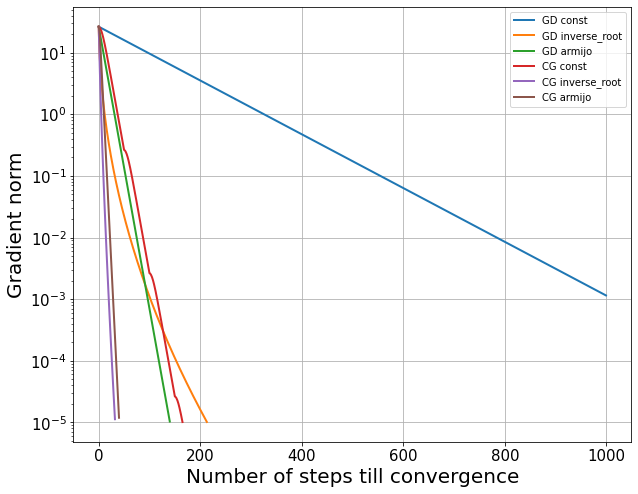

In [21]:
opt = {
    "GD": gd,
    "CG": cg
}

alphas = {
    "const": Const(alpha_0=.01),
    "inverse_root": InverseRoot(alpha_0=.5),
    "armijo": Armijo(alpha_0=.1, rho=0.5, beta=0.1, get_next_x=lambda x, alpha, h: x + alpha * h)
}

plt.figure(figsize=(10, 8))
for opt_method_name, opt_method in tqdm(opt.items()):
    for alpha_name, alpha in alphas.items():
        points = opt_method(w0, f, autograd_f, alpha)
        plt.semilogy(
            [np.linalg.norm(autograd_f(x)) for x in points], 
            label=f"{opt_method_name} {alpha_name}", 
            linewidth=2
        )
plt.grid()
plt.ylabel("Gradient norm", fontsize=20)
plt.xlabel("Number of steps till convergence", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.show()

> From this experiment we can see that even after tuning values of $\alpha$ for GD, CG outperforms it significantly. Moreover, for $\alpha^{\text{const}}$ method GD did not even converged in 1000 iterations

### Experiment 2

$$\text{MSE} = \frac{1}{N}(\textbf{y} - \textbf{X} \textbf{w}) ^ T (\textbf{y} - \textbf{X} \textbf{w}) = \frac{1}{N}\left(\textbf{w}^T \textbf{X}^T  \textbf{X} \textbf{w} -  2 \textbf{y}^T \textbf{X}  \textbf{w} +  \textbf{y}^T \textbf{y}\right)$$
$$\min_{\textbf{w}} MSE = \min_{\textbf{w}} \frac{1}{N}\left(\textbf{w}^T \textbf{X}^T  \textbf{X} \textbf{w} -  2 \textbf{y}^T \textbf{X}  \textbf{w} \right)$$
Lets denote $\textbf{A} = \frac{2}{N} \textbf{X}^T  \textbf{X}$, and $\textbf{b} = \frac{2}{N}\textbf{X}^T \textbf{y} $, then the optimization problem can be rewriten as usual quatratic programming task:
$$\min_{\textbf{w}} MSE = \min_{\textbf{w}} \frac{1}{2}\textbf{w}^T A \textbf{w} -  \textbf{b}^T  \textbf{w} $$
For Conjugate Gradient in quadratic optimization the value of $\alpha$

In [11]:
@jax.jit
def mse(w):
    e = y - X @ w
    return e.T @ e / X.shape[0]

autograd_mse = jax.jit(jax.grad(mse))

In [12]:
A = 2 * X.T @ X / X.shape[0]
b = 2 * X.T @ y / X.shape[0]

In [13]:
(A != 0).sum() / A.shape[0] ** 2

DeviceArray(0.9829217, dtype=float64)

In [14]:
def cg_quad(x0, A, b, max_iter: int = 1000, eps: float = 1e-5, restart: int = 5000):
    x_values = []
    x = x0
    r = A @ x0 - b
    p = -r
    iter_ = 0
    while np.linalg.norm(r) > eps:
        x_values.append(x)
        alpha = (r.T @ r) / (p.T @ A @ p)
        x = x + alpha * p

        r_next = r + alpha * (A @ p)
        beta = (r_next.T @ r_next) / (r.T @ r)
        p = -r_next + beta * p
        r = r_next
        
        iter_ += 1
        
        if (restart is not None) and (not iter_ % restart):
            grad = A @ x - b
            p = -grad
    

    return x_values

100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.16s/it]


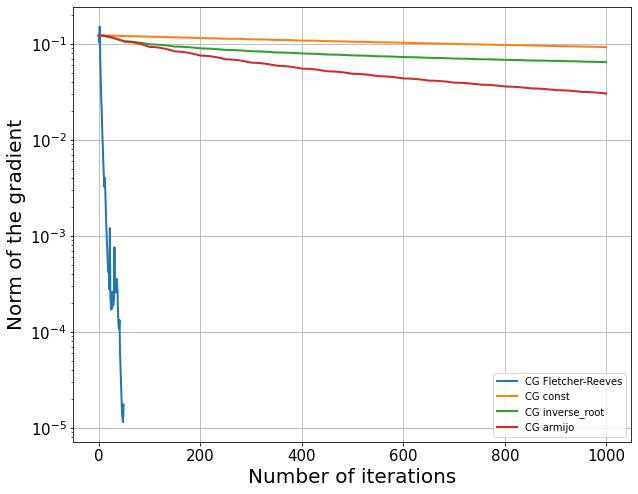

In [15]:
points = cg_quad(w0, A, b)
plt.figure(figsize=(10, 8))
plt.semilogy(
    [np.linalg.norm(A @ x_ - b) for x_ in points], 
    linewidth=2,
    label=f"CG Fletcher-Reeves", 
)
for alpha_name, alpha in tqdm(alphas.items()):
    points = opt_method(w0, mse, autograd_mse, alpha)
    plt.semilogy(
        [np.linalg.norm(autograd_mse(x)) for x in points], 
        label=f"CG {alpha_name}", 
        linewidth=2
    )
plt.ylabel("Norm of the gradient", fontsize=20)
plt.xlabel("Number of iterations", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend()

### Experiment 3

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
from scipy.linalg import sqrtm
import scipy.sparse as sparse
import scipy.optimize as scopt

In this experiment we want to investigate how the convergence speed of CG depend on the distribution of eigen values of matrix $A$ in quadratic optimization problem. Here we will cover the following scenario. We will make $A$ to be semetric real-valued matrix, and eigen values are uniformely distributed on certain interval. Note that in this case eigenvalues will be also real-valued, and we will designe this matrix in such a way that all eigenvalues are positive, i.e. $A$ is positive defined. 

In [17]:
from dataclasses import dataclass
import typing as tp

@dataclass
class Cluster:
    """Cluster information holder"""
    center: complex
    radius: float
    size: int

In [18]:
def cluster_submatrix(
    cluster: Cluster = Cluster(0.5, 1, 10), 
    symmetric: bool = False
) -> np.array:
    assert np.absolute(cluster.center) >= 0.5, "Not positive deffined matrix will be generated"
    matrix = np.random.normal(size=(cluster.size, cluster.size))
    # Making symmetric
    offset = cluster.center
    if symmetric:
        matrix = (matrix + matrix.T) / (2 * np.sqrt(2))
        offset = np.real(offset)
    # Scaling matrix to unit varience and zero mean
    matrix *= 1 / np.sqrt(cluster.size)
    # Changing mean and variance to defined in cluster
    matrix = matrix * cluster.radius + offset * np.eye(cluster.size, cluster.size)
    return matrix

def plot_eigvals(matrix: np.array, symmetric: bool) -> None:
    eigvals = np.linalg.eigvals(matrix)
    plt.figure(figsize=(7,2.5))
    plt.scatter(np.real(eigvals), np.imag(eigvals))
    plt.xlabel("Real part", fontsize=20)
    plt.ylabel("Imag part", fontsize=20)
    plt.xticks(fontsize=18)
    _ = plt.yticks(fontsize=18)
    if symmetric:
        plt.title("Distribution of eigvals for symmetric", fontsize=20)
    else:
        plt.title("Distribution of complex-value eigvals", fontsize=20)
    plt.grid()
    plt.show()

def generate_matrix(
    clusters: tp.List[Cluster], 
    symmetric: bool = True,
    plot: bool = False
) -> np.array:
    full_size = np.sum([cluster.size for cluster in clusters])
    matrix = np.zeros((full_size, full_size))
    if not symmetric:
        matrix = matrix.astype(complex)
    already_filled = 0
    for cluster in clusters:
        matrix[already_filled: already_filled + cluster.size,
               already_filled: already_filled + cluster.size] = cluster_submatrix(cluster, symmetric)
        already_filled += cluster.size
    if plot:
        plot_eigvals(matrix, symmetric=symmetric)
    return matrix

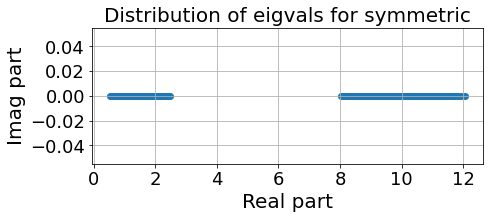

In [19]:
clasters = [
    Cluster(center=1.5, radius=1, size=100),
    Cluster(center=10, radius=2, size=190),
]
A = generate_matrix(clasters, symmetric=True, plot=True)

**1** Lets fix the center of the cluster, but will change the radius of the cluster

In [20]:
N = 250
b = np.random.random(N)
x0 = np.random.random(N)

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


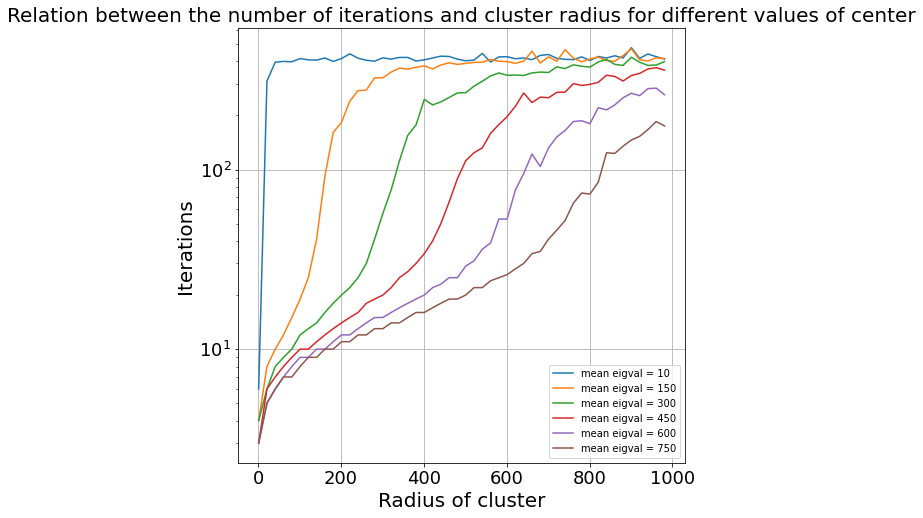

In [21]:
def const_center(
    center: complex, 
    radiuses: tp.List[float], 
    dim: int, 
    b: np.array,
    x0: np.array
) -> tp.List[float]:
    const_center_logs = []
    for r in radiuses:
        A = generate_matrix([Cluster(radius=r, center=center, size=dim)], symmetric=True)
        res = cg_quad(x0, A, b)
        const_center_logs.append(len(res))
    return const_center_logs

radiuses = range(1, 1000, 20)
centers = [10, 150, 300, 450, 600, 750]
plt.figure(figsize=(8,8))
for center in tqdm(centers):
    log = const_center(center=center, radiuses=radiuses, dim=N, b=b, x0=x0)
    plt.semilogy(radiuses, log, label=f"mean eigval = {round(center,2)}")
plt.title("Relation between the number of iterations and cluster radius for different values of center", fontsize=20)
plt.xlabel("Radius of cluster", fontsize=20)
plt.ylabel("Iterations", fontsize=20)
plt.legend()
plt.grid()
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

> If our cluster has a small radius, then its condition number (https://en.wikipedia.org/wiki/Condition_number) is close to 1, so the method should converge rather quickly. Moreover for all methods we can see taht at the point where radius equals the number of iterations incresed dramaticly, since when radius excides the mean value matrix $A$ is no longer positive defined. In addition, at the very end all methods start to oscillate in the coherence of $2N$ iterations, indicating that the method still works, and not bad at all.

**2** Let's now fix radius and varay mean value

100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.97it/s]


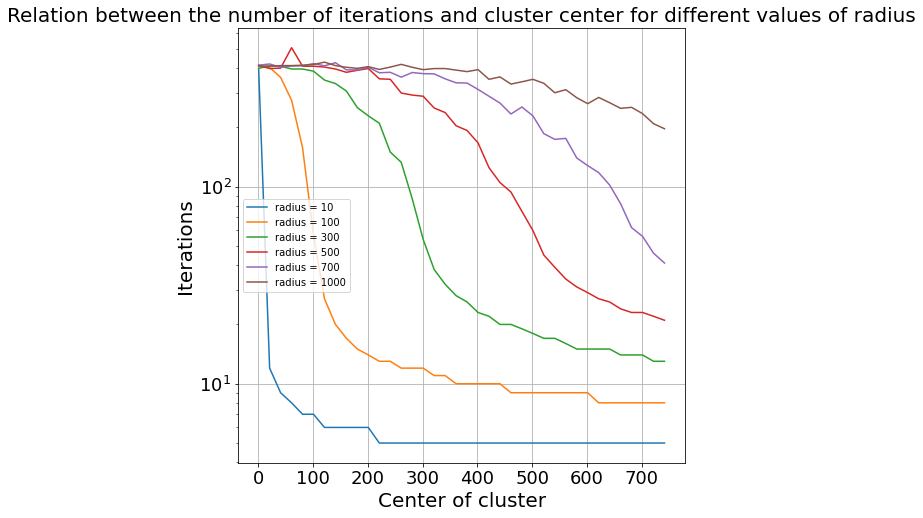

In [25]:
def const_radius(
    radius: float, 
    centers: tp.List[float], 
    dim: int, 
    b: np.array,
    x0: np.array
) -> tp.List[float]:
    const_radius_logs = []
    for center in centers:
        A = generate_matrix([Cluster(radius=radius, center=center, size=dim)], symmetric=True)
        res = cg_quad(x0, A, b)
        const_radius_logs.append(len(res))
    return const_radius_logs

centers = range(1, 750, 20)
radiuses = [10, 100, 300, 500, 700, 1000]
plt.figure(figsize=(8,8))
for r in tqdm(radiuses):
    log = const_radius(centers=centers, radius=r, dim=N, b=b, x0=x0)
    plt.semilogy(centers, log, label=f"radius = {round(r,2)}")
plt.title("Relation between the number of iterations and cluster center for different values of radius", fontsize=20)
plt.xlabel("Center of cluster", fontsize=20)
plt.ylabel("Iterations", fontsize=20)
plt.legend()
plt.grid()
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

> The obtained results are consistent with the results of the previous experiment. Again, we can see that when the radius of the cluster becomes larger than the average value in the matrix cluster, the matrix is no longer positive defined, which leads to worse convergence

### Experiment 4

Now lets fix certain deistribution of random values and lets vary the level of sparsity of matrix $A$

In [79]:
from scipy.sparse import random
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix
from numpy.random import default_rng
import scipy.linalg as la

from collections import defaultdict
import math

In [209]:
rng = default_rng()
rvs = stats.poisson(25, loc=10).rvs

As we have seen in previous experiment, the distribution of eigenvalues of the matrix has a huge influence of convergence. We have not found any convinient method to sample random sparse matrices with given set of eigenvalues, so we emploied the following trick. First we sample random sparce matrix, then make it symmetric, and then "scale" it. Since our matrix is real-valued and symmetric, substraction of diagonal matrix, and devision of each component on a constant value does not breake the sparsity of matrix.

In [533]:
def generate_random_sparse(density: float):
    sparse = random(N, N, density=density, random_state=rng)
    sparse = (sparse + sparse.T) / 2
    eigvals = np.linalg.eigvals(sparse.A)
    eig_mean, eig_std = eigvals.mean(), eigvals.std()
    sparse = (sparse - np.eye(N) * eig_mean) / eig_std
    return sparse

In [535]:
def cg_quad_sparse(x0, A, b, max_iter: int = 1000, eps: float = 1e-7, restart: int = 5000):
    x_values = []
    x = x0
    r = A @ x0 - b
    p = -r
    while np.linalg.norm(r) > eps:
        x_values.append(x)
        alpha = (r @ r.T) / (p @ A @ p.T)
        x = x + alpha * p

        r_next = r + alpha * (p @ A.T)
        beta = (r_next @ r_next.T) / (r @ r.T)
        p = -r_next + beta * p
        r = r_next
        
        if (restart is not None) and (not iter_ % restart):
            grad = A @ x.T - b
            p = -grad
    

    return x_values

In [649]:
def densities(N):
    output = defaultdict(list)
    convergence = []

    total = 50
    for _ in tqdm(range(10)):
        b = np.random.random(N)
        x0 = np.random.random(N)
        for density in [0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.8]:
            for i in range(5):
                sparse = generate_random_sparse(density)
                if not i:
                    share_of_zeros = math.floor((sparse == 0).sum() / N / N * 100)
                res = cg_quad_sparse(x0, sparse, b, max_iter=100000)
                output[share_of_zeros].append(len(res))
            convergence.append([np.linalg.norm(sparse @ x.T - b) for x in res])
    output = {k: np.array(v) for k, v in output.items()}
    return output

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


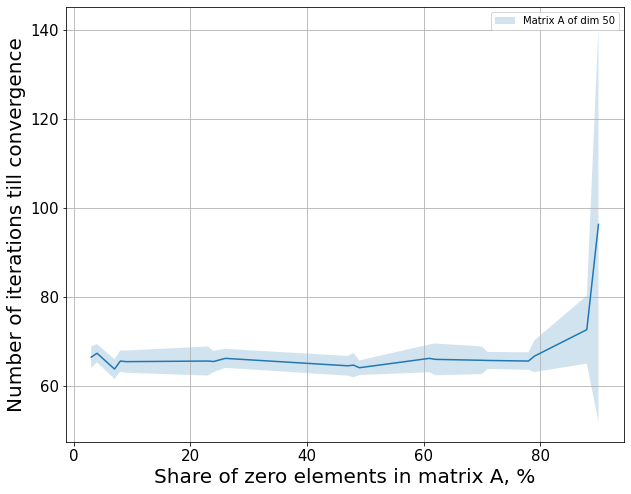

In [660]:
plt.figure(figsize=(10, 8))
for N in [50, 100, 150, 200, 500, 1000]:
    output = densities(N)
    output = dict(sorted(output.items(), key=lambda x: x[0]))
    plt.plot(output.keys(), [v.mean() for v in output.values()])
    plt.fill_between(
        output.keys(), 
        [v.mean() - v.std() for v in output.values()], 
        [v.mean() + v.std() for v in output.values()], 
        alpha=0.2,
        label=f"Matrix A of dim {N}"
    )
    plt.xlabel("Share of zero elements in matrix A, %", fontsize=20)
    plt.ylabel("Number of iterations till convergence", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.grid()
plt.legend()

> As a conclusion we can say that sparsity does not affect the convergence of the method as much as we expected. However, it is possible that the difference will be more signifficant with really huge matrices $A$. We haven't tested such hypothesis due to limited computational resources